## This was done on Google Colab 
---
Go to https://colab.research.google.com/notebooks/, you will see a tutorial named "Welcome to Colaboratory" file, where you can learn the basics of using google colab.

## Enable Colab GPU Acceleration
---
Navigation menu: **Runtime->Change runtime type->Hardware accelerator->GPU**


* **Install Python packages**: install Python packages: `numpy`, `matplotlib`, `opencv-python` using pip, for example:
```
pip install numpy matplotlib opencv-python
``` 
	Note that when using “pip install”, make sure that the version you are using is python3. Below are some commands to check which python version it uses in you machine. You can pick one to execute:
  
```
    pip show pip
    pip --version
    pip -V
```

In case of the wrong version, use `pip3` for python3 explictly.


## Description
---
In this, we will implement an image-to-image translation method, based on
[pix2pix](https://phillipi.github.io/pix2pix/). To be more specific,  we'll built from scratch a GAN which can translate abstract labels into facade images. 

Before we start, please read the [pix2pix paper](https://arxiv.org/pdf/1611.07004.pdf) first and understand how pix2pix works.



In [ ]:
# Mount your google drive where you've saved your assignment folder
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd '/content/gdrive/MyDrive'

/content/gdrive/.shortcut-targets-by-id/1XmnGVXhb0JuhcMYgG_QQ1eyE0O1iS1dC/Singh_Hiteshwar_115076518_hw5


### Part 1 Load dataset
---

We'll train a model to generate pictures of facades from label maps, using the [CMP Facade
Database](http://cmp.felk.cvut.cz/~tylecr1/facade/) . This dataset contains 606 rectified images of facades from various sources, which have been manually annotated.


Load the training set and test set under the folder `./facades`. Normalize the images to $[-1, 1]$. For each set, return a batch list. Show one image from the training set and its label side by side in a `1x2` grid.

In [ ]:
# # download the dataset
# ! chmod +x ./download_dataset.sh
# ! ./download_dataset.sh

In [ ]:
!pip install utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import random 
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import utils

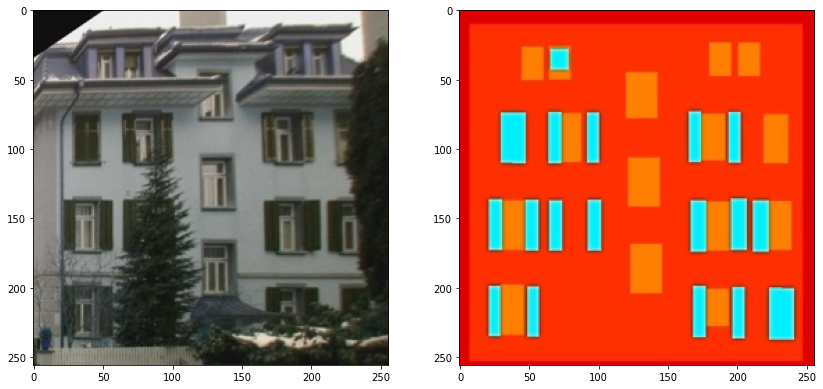

In [ ]:
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

def load_dataset(path, shuffle=False):
    # load the images under the folder
    # remember to normalize them to [-1, 1]
    image_names = [name for name in glob.glob(path + '/*.jpg')]
    data = []
    for img_name in image_names:
      img = cv2.imread(img_name, cv2.COLOR_BGR2RGB)
      # print("Img shape:", img.shape)
      transform = transforms.Compose([transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])

      tensor_img = transform(img)
      # tensor_img = (tensor_imgp*2) - 1
      # print("Tensor Img Size", tensor_img.shape)
      ground_truth = tensor_img[:,:,:256]
      label = tensor_img[:,:,256:]
      # print("GT", ground_truth.shape)
      # print("label", label.shape)
      
      # print("Tensor Permute Img Size", label.shape)
      # print("Tensor Permute Img Size", ground_truth.shape)
      instance = (ground_truth,label)
      data.append(instance)
    # return a list of tuples.
    # for each tuple, the first element is ground truth, the second one is label image
    # both images should be tensors
    return data


set_seeds(302)
train = load_dataset('./facades/train', shuffle=True)
train_data_loader = torch.utils.data.DataLoader(dataset=train,
                                                batch_size=1,
                                                shuffle=True)
test = load_dataset('./facades/test')
test_data_loader = torch.utils.data.DataLoader(dataset=test,
                                                batch_size=4)

def convert_zero(img):
  return (img+1)/2
def show_img_pair(s_left, s_right):
    # convert the pixels back to [0, 1] when visualizing
    
    s_right = convert_zero(s_right)
    s_left = convert_zero(s_left)

    s_right = s_right.permute(1,2,0)
    s_left = s_left.permute(1,2,0)
    plt.figure(figsize=(14,8))
    plt.subplot(1, 2, 1)
    plt.imshow(s_left)

    plt.subplot(1, 2, 2)
    plt.imshow(s_right)
    
    
idx = 150
show_img_pair(train[idx][0], train[idx][1])

#still normalization to do 

### Part 2 Models
---
In this part, we will define the network based on the architectures from the paper.
Please check the Appendix of the paper for the details of this architecture.

Let $Ck$ denote a Convolution-BatchNorm-ReLU layer with k filters. $CDk$
denotes a Convolution-BatchNormDropout-ReLU layer with a dropout rate of 50%. All
convolutions are 4 x 4 spatial filters applied with stride 2. Convolutions in the encoder,
and in the discriminator, downsample the input by a factor of 2, whereas in the decoder
they upsample the input by a factor of 2.

(a) Generator
The U-Net encoder-decoder architecture consists of:

U-Net encoder:
$$C64-C128-C256-C512-C512-C512-C512-C512$$

U-Net decoder:

$$CD512-CD1024-CD1024-C1024-C1024-C512-C256-C128$$

After the last layer in the decoder, a convolution is applied to map to the number
of output channels, which is `3` in our problem, followed by a `tanh` function. As a
special case, batch normalization is not applied to the first $C64$ layer in the encoder.
All ReLUs in the encoder are leaky, with slope `0.2`, while ReLUs in the decoder are
not leaky.
If you are not familiar with the architecture of UNet, please check [this paper](https://arxiv.org/abs/1505.04597) first.

(b) Discriminator

The discriminator architecture is:
$$C64-C128-C256-C512$$
After the last layer, a convolution is applied to map to a 1-dimensional output,
followed by a sigmoid function. As an exception to the above notation, batch
normalization is not applied to the first $C64$ layer. All ReLUs are leaky, with slope
`0.2`.

Hint: Use `torch.nn.functional.leaky_relu` for leaky ReLU.

In [ ]:
class ConvBlock(torch.nn.Module):
    def __init__(self, input_size, output_size, kernel_size=4, stride=2, padding=1, activation=True, batch_norm=True):
        super(ConvBlock, self).__init__()
        self.conv = torch.nn.Conv2d(input_size, output_size, kernel_size, stride, padding)
        self.activation = activation
        self.lrelu = torch.nn.LeakyReLU(0.2, True)
        self.batch_norm = batch_norm
        self.bn = torch.nn.BatchNorm2d(output_size)

    def forward(self, x):
        if self.activation:
            out = self.conv(self.lrelu(x))
        else:
            out = self.conv(x)

        if self.batch_norm:
            return self.bn(out)
        else:
            return out


class DeconvBlock(torch.nn.Module):
    def __init__(self, input_size, output_size, kernel_size=4, stride=2, padding=1, batch_norm=True, dropout=False):
        super(DeconvBlock, self).__init__()
        self.deconv = torch.nn.ConvTranspose2d(input_size, output_size, kernel_size, stride, padding)
        self.bn = torch.nn.BatchNorm2d(output_size)
        self.drop = torch.nn.Dropout(0.5)
        self.relu = torch.nn.ReLU(True)
        self.batch_norm = batch_norm
        self.dropout = dropout

    def forward(self, x):
        if self.batch_norm:
            out = self.bn(self.deconv(self.relu(x)))
        else:
            out = self.deconv(self.relu(x))

        if self.dropout:
            return self.drop(out)
        else:
            return out

In [ ]:
# discriminator
class Discriminator(nn.Module):
    def __init__(self, n_channels):
        # n_channels means num of input channels
        super(Discriminator, self).__init__()
        self.output_dim = 1
        self.num_filter = 64
    
        self.conv1 = ConvBlock(n_channels, self.num_filter, activation=False, batch_norm=False)
        self.conv2 = ConvBlock(self.num_filter, self.num_filter * 2)
        self.conv3 = ConvBlock(self.num_filter * 2, self.num_filter * 4)
        self.conv4 = ConvBlock(self.num_filter * 4, self.num_filter * 8)
        self.conv5 = ConvBlock(self.num_filter * 8, self.output_dim, stride = 1, batch_norm=False)

        
    def forward(self, x, label):
        x = torch.cat([x, label], 1)
        # print("X shape", x.shape)
        x = self.conv1(x)
        # print("X shape", x.shape)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x_d = torch.nn.Sigmoid()(x)
        return x_d

 # initialize the discriminator
netD = Discriminator(6)
# feel free to do some sanity check here


In [ ]:
class Generator(nn.Module):
    def __init__(self, n_channels):
        super(Generator, self).__init__()
        # output dimension = 3
        self.output_dim = 3
        self.num_filter = 64
        # Encoder
        self.conv1 = ConvBlock(n_channels, self.num_filter, activation=False, batch_norm=False)
        self.conv2 = ConvBlock(self.num_filter, self.num_filter * 2)
        self.conv3 = ConvBlock(self.num_filter * 2, self.num_filter * 4)
        self.conv4 = ConvBlock(self.num_filter * 4, self.num_filter * 8)
        self.conv5 = ConvBlock(self.num_filter * 8, self.num_filter * 8)
        self.conv6 = ConvBlock(self.num_filter * 8, self.num_filter * 8)
        self.conv7 = ConvBlock(self.num_filter * 8, self.num_filter * 8, batch_norm=False)
        # Decoder
        self.deconv1 = DeconvBlock(self.num_filter * 8, self.num_filter * 8, dropout=True)
        self.deconv2 = DeconvBlock(self.num_filter * 8 * 2, self.num_filter * 8, dropout=True)
        self.deconv3 = DeconvBlock(self.num_filter * 8 * 2, self.num_filter * 8, dropout=True)
        self.deconv4 = DeconvBlock(self.num_filter * 8 * 2, self.num_filter * 4)
        self.deconv5 = DeconvBlock(self.num_filter * 4 * 2, self.num_filter * 2)
        self.deconv6 = DeconvBlock(self.num_filter * 2 * 2, self.num_filter)
        self.deconv7 = DeconvBlock(self.num_filter * 2, self.output_dim, batch_norm=False)
        
    
    def forward(self, x):   
        enc1 = self.conv1(x)
        enc2 = self.conv2(enc1)
        enc3 = self.conv3(enc2)
        enc4 = self.conv4(enc3)
        enc5 = self.conv5(enc4)
        enc6 = self.conv6(enc5)
        enc7 = self.conv7(enc6)
        # Decoder with skip-connections
        dec1 = self.deconv1(enc7)
        dec1 = torch.cat([dec1, enc6], 1)
        dec2 = self.deconv2(dec1)
        dec2 = torch.cat([dec2, enc5], 1)
        dec3 = self.deconv3(dec2)
        dec3 = torch.cat([dec3, enc4], 1)
        dec4 = self.deconv4(dec3)
        dec4 = torch.cat([dec4, enc3], 1)
        dec5 = self.deconv5(dec4)
        dec5 = torch.cat([dec5, enc2], 1)
        dec6 = self.deconv6(dec5)
        dec6 = torch.cat([dec6, enc1], 1)
        dec7 = self.deconv7(dec6)
        x_g = torch.nn.Tanh()(dec7)
        
        return x_g


# initialize the discriminator
netG = Generator(3)

# feel free to do some sanity check here


In [ ]:
netGL1 = Generator(3)

### Part 3 Optimizor
---
For optimization, we'll use the Adam optimizer, with a learning rate of `0.0002`, and momentum parameters  $\beta_1= 0.5$; $\beta_2 = 0.999$.

In [ ]:
# Define the optimizors here, make sure you give them the right parameters

netD_optimizer = torch.optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
netG_optimizer = torch.optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:
netGL1_optimizer = torch.optim.Adam(netGL1.parameters(), lr=0.0002, betas=(0.5, 0.999))


### Part 4 Training
---
For each batch, first train discriminator D by using the average loss of real image and fake image. Then train generator G by using the following loss equation.
$$G^*=\arg \min_{G} \max_{D} L_{cGAN}(G, D) + \lambda L_{L1}(G) $$

In this homework, you will train two different models: one using only the L1 loss, the other using the equation above with $\lambda = 100$. 

As a sanity check, please compare your results with those in the paper (e.g. Figure 4) to make sure they roughly match.

Train the network for at least 20 epochs (at least 10 epochs for the model with only L1 loss,) but you are encouraged to train longer to obtain better results. (In the paper, they train
for 200 epochs.) Save your models to `pix2pix.pth` and `pix2pixL1.pth` using the given code. 

Note: Training training each epoch should take less than 2 minutes if you are using Colab. **Remember to save your models regularly** so you won't lose your progress accidentally.

In the end, plot the Generator/Discriminator (G/D) loss history (averaged per epoch) of the two models with respect to the epoch in two plots. i.e. the first plot should contain the G/D loss of the model with L1 and cGAN, the second plot should contain the L1 loss of the other model.


In [ ]:
from torch.autograd import Variable

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

netG = netG.to(device)
netD = netD.to(device)

In [ ]:

netG.train()
netD.train()


num_epochs = 50
m_lambda = 100


BCE_loss = torch.nn.BCEWithLogitsLoss()
L1_loss = torch.nn.L1Loss()

D_avg_losses = []
G_avg_losses = []

for epoch in range(num_epochs):
  print("====================================================================")
  D_losses = []
  G_losses = []
  print("Running Epoch",epoch,"/",num_epochs)
  check = 0
  for i, (ground_truth, label) in enumerate(train_data_loader):

    # input & target image data

    # print("Input Shape 1", ground_truth.shape)
    ground_truth = Variable(ground_truth.cuda())
    label = Variable(label.cuda())

    # Train discriminator with real data

    # Train discriminator with real data
    D_real_decision = netD(ground_truth, label).squeeze()
    real_ = Variable(torch.ones(D_real_decision.size()).cuda())
    D_real_loss = BCE_loss(D_real_decision, real_)
    
    # Train discriminator with fake data
    gen_image = netG(label)
    D_fake_decision = netD(ground_truth, gen_image).squeeze()
    fake_ = Variable(torch.zeros(D_fake_decision.size()).cuda())
    D_fake_loss = BCE_loss(D_fake_decision, fake_)


# Optional
    # Back propagation
    D_loss = (D_real_loss + D_fake_loss) * 0.5
    
    # wandb.log({"D_loss": D_loss})

    # Train generator
    # gen_image = netG(ground_truth)
    # D_fake_decision = netD(ground_truth, gen_image).squeeze()
    # real1_ = Variable(torch.ones(D_fake_decision.size()).cuda())
    # G_fake_loss = BCE_loss(D_fake_decision, real1_)

    # L1 loss
    L1 = L1_loss(gen_image, ground_truth)
    l1_loss = m_lambda * L1
    # wandb.log({"l1_loss": l1_loss})

    # Back propagation
    G_loss = D_loss + l1_loss
    # print("G_loss",G_loss)
    # wandb.log({"G_loss": G_loss})
    
    netG.zero_grad()
    netD.zero_grad()

    G_loss.backward()
    netG_optimizer.step()

    # D_loss.backward()
    netD_optimizer.step()

    # loss values
    D_losses.append(D_loss.data.item())
    G_losses.append(G_loss.data.item())
  
  
  D_avg_loss = torch.mean(torch.FloatTensor(D_losses))
  G_avg_loss = torch.mean(torch.FloatTensor(G_losses))
  # avg loss values for plot

  D_avg_losses.append(D_avg_loss)
  G_avg_losses.append(G_avg_loss)


  print('Epoch [%d/%d], D_loss: %.4f, G_loss: %.4f'
        % (epoch+1, num_epochs,  D_loss.data.item(), G_loss.data.item() ))


Running Epoch 0 / 50
Epoch [1/50], D_loss: 0.5160, G_loss: 31.2250
Running Epoch 1 / 50
Epoch [2/50], D_loss: 0.5159, G_loss: 46.2465
Running Epoch 2 / 50
Epoch [3/50], D_loss: 0.5159, G_loss: 35.2564
Running Epoch 3 / 50
Epoch [4/50], D_loss: 0.5159, G_loss: 28.4721
Running Epoch 4 / 50
Epoch [5/50], D_loss: 0.5159, G_loss: 28.4432
Running Epoch 5 / 50
Epoch [6/50], D_loss: 0.5159, G_loss: 31.9898
Running Epoch 6 / 50
Epoch [7/50], D_loss: 0.5159, G_loss: 29.8333
Running Epoch 7 / 50
Epoch [8/50], D_loss: 0.5159, G_loss: 33.0904
Running Epoch 8 / 50
Epoch [9/50], D_loss: 0.5159, G_loss: 29.6549
Running Epoch 9 / 50
Epoch [10/50], D_loss: 0.5159, G_loss: 32.5171
Running Epoch 10 / 50
Epoch [11/50], D_loss: 0.5159, G_loss: 30.2498
Running Epoch 11 / 50
Epoch [12/50], D_loss: 0.5159, G_loss: 25.0819
Running Epoch 12 / 50
Epoch [13/50], D_loss: 0.5159, G_loss: 26.1728
Running Epoch 13 / 50
Epoch [14/50], D_loss: 0.5159, G_loss: 39.0525
Running Epoch 14 / 50
Epoch [15/50], D_loss: 0.5159, 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
netGL1 = netGL1.to(device)

In [ ]:

netGL1.train()
num_epochs = 50

L1_loss2 = torch.nn.L1Loss()
GL1_avg_losses = []

for epoch in range(num_epochs):
  GL1_losses =[]
  print("====================================================================")

  print("Running Epoch",epoch,"/",num_epochs)
  
  for i, (ground_truth, label) in enumerate(train_data_loader):

    # input & target image data

    ground_truth = Variable(ground_truth.cuda())
    label = Variable(label.cuda())

    # Train generator
    gen_image = netGL1(label)
    
    GL1_loss = L1_loss2(gen_image, ground_truth) 
    # wandb.log({"GL1_loss_new": GL1_loss})

    # Back propagation

    netGL1.zero_grad()
    GL1_loss.backward()
    netGL1_optimizer.step()

    # loss values
    GL1_losses.append(GL1_loss)

  
  GL1_avg_loss = torch.mean(torch.FloatTensor(GL1_losses))
  # avg loss values for plot

  GL1_avg_losses.append(GL1_avg_loss)


  print('Epoch [%d/%d], G_loss: %.4f'
        % (epoch+1, num_epochs, GL1_avg_loss.data.item() ))


Running Epoch 0 / 50
Epoch [1/50], G_loss: 0.4619
Running Epoch 1 / 50
Epoch [2/50], G_loss: 0.3795
Running Epoch 2 / 50
Epoch [3/50], G_loss: 0.3627
Running Epoch 3 / 50
Epoch [4/50], G_loss: 0.3513
Running Epoch 4 / 50
Epoch [5/50], G_loss: 0.3442
Running Epoch 5 / 50
Epoch [6/50], G_loss: 0.3359
Running Epoch 6 / 50
Epoch [7/50], G_loss: 0.3272
Running Epoch 7 / 50
Epoch [8/50], G_loss: 0.3184
Running Epoch 8 / 50
Epoch [9/50], G_loss: 0.3095
Running Epoch 9 / 50
Epoch [10/50], G_loss: 0.2993
Running Epoch 10 / 50
Epoch [11/50], G_loss: 0.2910
Running Epoch 11 / 50
Epoch [12/50], G_loss: 0.2798
Running Epoch 12 / 50
Epoch [13/50], G_loss: 0.2694
Running Epoch 13 / 50
Epoch [14/50], G_loss: 0.2605
Running Epoch 14 / 50
Epoch [15/50], G_loss: 0.2502
Running Epoch 15 / 50
Epoch [16/50], G_loss: 0.2409
Running Epoch 16 / 50
Epoch [17/50], G_loss: 0.2314
Running Epoch 17 / 50
Epoch [18/50], G_loss: 0.2223
Running Epoch 18 / 50
Epoch [19/50], G_loss: 0.2117
Running Epoch 19 / 50
Epoch [20

In [ ]:
# codes for saving models, feel free to change them
torch.save({
    'G': netG.state_dict(),
    'D': netD.state_dict(),
    }, 'pix2pix.pth')

torch.save({
    'G': netGL1.state_dict(),
    }, 'pix2pixL1.pth')
# torch.save({
#     'Gd':netGd.state_dict(),
#     }, 'pix2pixd.pth')


In [ ]:
# codes for restoring models, feel free to change them

path = "pix2pix.pth"
checkpoint = torch.load(path)
netG.load_state_dict(checkpoint['G'])
netD.load_state_dict(checkpoint['D'])

path = "pix2pixL1.pth"
checkpoint = torch.load(path)
netGL1.load_state_dict(checkpoint['G'])


# path = "pix2pixd.pth"
# checkpoint = torch.load(path)
# netDd.load_state_dict(checkpoint['Gd'])


<All keys matched successfully>

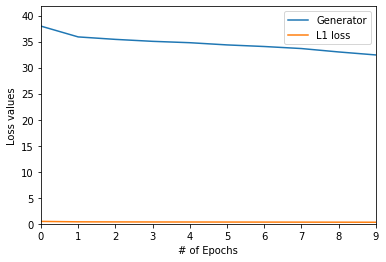

In [ ]:
# Plot the loss

def plot_loss(g_losses,l1_losses, num_epochs, save=False, save_dir='results/', show=False):
    fig, ax = plt.subplots()
    ax.set_xlim(0, num_epochs-1)
    ax.set_ylim(0, max(np.max(g_losses), np.max(l1_losses))*1.1)
    plt.xlabel('# of Epochs')
    plt.ylabel('Loss values')
    plt.plot(g_losses, label='Generator')
    plt.plot(l1_losses, label= "L1 loss")
    plt.legend()
    if show:
        plt.show()
    else:
        plt.close()
plot_loss(G_avg_losses,GL1_avg_losses, 10,show=True)

### Part 5 Evaluation
---

Compared to a classification problem, evaluating an image translation model could be tricky because we don't always have the ground-truth available. There are several different ways to compare the performance of different GAN models:

1. Visualize the generated images of different GAN models. 

2. Compute a distance, such as **Frechet Inception Distance** (**FID**, the smaller the better, [paper](https://arxiv.org/abs/1706.08500)), between the generated images and the real images, or compute the Inception Score (**IS**, the higher the better, [paper](https://arxiv.org/pdf/1606.03498.pdf)) for the generated images. We strongly encourage you to read these papers.

3. Using generated images for downstream tasks, such as classification, segmentation, etc. and computing the task accuracy.

Now it's your turn to evaluate the models you trained. 

 We'll first visualize `4` test samples and plot them as in Figure 4 in the pix2pix paper, to get some qualitative results. You can select any interesting samples from the **test set**.

 Then let's do some quantitative analysis. Adapt this **Inception Score** ([ref](https://github.com/sbarratt/inception-score-pytorch/blob/master/inception_score.py)) implementation, and report the mean score of each model on the test set. Again, you are encouraged to train your models longer.

In [ ]:
# Visualization
# Please read Figure 4 in the pix2pix paper first

def plot_test_result(input, target, gen_image1, gen_image2):
    
    fig = plt.figure(figsize=(15, 15))
  
    # setting values to rows and column variables
    rows = 1
    columns = 4
      
    input = convert_zero(input)
    # target = convert_zero(target)
    # gen_image1 = convert_zero(gen_image1)
    # gen_image2 = convert_zero(gen_image2)
      
    # Adds a subplot at the 1st position
    fig.add_subplot(rows, columns, 1)
      
    # showing image
    plt.imshow(input)
    plt.axis('off')
    plt.title("Input")
      
    # Adds a subplot at the 2nd position
    fig.add_subplot(rows, columns, 2)
      
    # showing image
    plt.imshow(target)
    plt.axis('off')
    plt.title("Target")
      
    # Adds a subplot at the 3rd position
    fig.add_subplot(rows, columns, 3)
      
    # showing image
    plt.imshow(gen_image1)
    plt.axis('off')
    plt.title("L1")
      
    # Adds a subplot at the 4th position
    fig.add_subplot(rows, columns, 4)
      
    # showing image
    plt.imshow(gen_image2)
    plt.axis('off')
    plt.title("L1+ cGAN")

    
    plt.show()


In [1]:
results = []
k = 0
for i, (ground_truth, label) in enumerate(test_data_loader):
    if k == 4:
      break;
    k+=1
    # input & target image data

    ground_truth = Variable(ground_truth.cuda())
    label = Variable(label.cuda())
    ground_truth = convert_zero(ground_truth)
    gen_image1 = netGL1(label)[0]
    gen_image2 = netG(label)[0]
    gen_image2 = convert_zero(gen_image2)
    gen_image1 = convert_zero(gen_image1)

    # print(gen_image1[0].shape)
    gen_image1 = gen_image1.squeeze().cpu().data.permute(1,2,0)
    gen_image2 = gen_image2.squeeze().cpu().data.permute(1,2,0)
    ground_truth = ground_truth[0].squeeze().cpu().data.permute(1,2,0)
    label = label[0].squeeze().cpu().data.permute(1,2,0)

    plot_test_result(label, ground_truth, gen_image1, gen_image2)
    # results.append([ground_truth, gen_image, label])


In [ ]:
import gc 
gc.collect()
# torch.cuda.empty_cache()

33958

In [ ]:
# Inception Scores
from torchvision.models.inception import inception_v3
from scipy.stats import entropy

dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
inception_model = inception_v3(pretrained=True, transform_input=False).type(dtype)
inception_model.eval();
up = nn.Upsample(size=(299, 299), mode='bilinear', align_corners=True).type(dtype)

def inception_score(images, splits=10,resize=True,):
    batch_size= 4
    N = len(images)*batch_size

    def get_pred(x):
        if resize:
            x = up(x)
        x = inception_model(x)
        return F.softmax(x).data.cpu().numpy()

    # Get predictions
    preds = np.zeros((N, 1000))
    # print(N)
    # print("Ored",preds.shape)
    for i, batch in enumerate(images, 0):
        batch = batch.type(dtype)
        batchv = Variable(batch)
        batch_size_i = batch.size()[0]
        vals = get_pred(batchv)
        
        preds[i*batch_size:i*batch_size + batch_size_i] = get_pred(batchv)


    # Now compute the mean kl-div
    split_scores = []

    for k in range(splits):
        part = preds[k * (N // splits): (k+1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))


    return np.mean(split_scores)


# Get the translation on test set
def prediction(model,data):
  output = []
  for i, (input, target) in enumerate(data):
    # input & target image data
    x_ = Variable(input.cuda())
    y_ = Variable(target.cuda())

    gen_image = model(x_)
    gen_image = (gen_image*2) -1 

    # gen_image = gen_image.cpu().data

    output.append(gen_image)

  return output

test_pred = prediction(netG, test_data_loader)
test_pred_l1 = prediction(netGL1, test_data_loader)
inception_s = inception_score(test_pred)
inception_s_l1 = inception_score(test_pred_l1)
print("IS for different losses, evaluated on facades dataset")
from IPython.display import HTML, display
import tabulate
table = [["Loss","IS ↑"],
         ["L1", f"{inception_s_l1:.4f}"],
         ["L1 + cGAN", f"{inception_s:.4f}"]]
display(HTML(tabulate.tabulate(table, tablefmt='html', headers="firstrow")))

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

<ipython-input-23-7b21c27a7b05>:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x).data.cpu().numpy()


IS for different losses, evaluated on facades dataset


Loss,IS ↑
L1,2.4426
L1 + cGAN,1.4008


### Spectral Normalization

Spectral normalization (**SN**, [paper](https://arxiv.org/abs/1802.05957)) is a simple and useful technique for stabilizing GAN training. Replace `batch normalization` with `spectral normalization` in both discriminator and generator, train the new model with the same L1 and cGAN loss for at least 20 epochs, then save the model to `pix2pixSN.pth`. Finally, perform the same evaluation you did in part 5 and compare the performance of all the models you trained.

use `torch.nn.utils.spectral_norm`.


In [ ]:
class ConvBlock(torch.nn.Module):
    def __init__(self, input_size, output_size, kernel_size=4, stride=2, padding=1, activation=True, batch_norm=True):
        super(ConvBlock, self).__init__()
        self.batch_norm = batch_norm

        if self.batch_norm:
          self.conv = torch.nn.utils.spectral_norm(torch.nn.Conv2d(input_size, output_size, kernel_size, stride, padding))
        else:
          self.conv = torch.nn.Conv2d(input_size, output_size, kernel_size, stride, padding)
        self.activation = activation
        
        self.lrelu = torch.nn.LeakyReLU(0.2, True)
        # self.bn = torch.nn.BatchNorm2d(output_size)

    def forward(self, x):
        if self.activation:
            out = self.conv(self.lrelu(x))
        else:
            out = self.conv(x)
        return out

        # if self.batch_norm:
        #     return self.bn(out)
        # else:


class DeconvBlock(torch.nn.Module):
    def __init__(self, input_size, output_size, kernel_size=4, stride=2, padding=1, batch_norm=True, dropout=False):
        super(DeconvBlock, self).__init__()
        self.batch_norm = batch_norm

        if self.batch_norm:
            self.deconv = torch.nn.utils.spectral_norm(torch.nn.ConvTranspose2d(input_size, output_size, kernel_size, stride, padding))
        else:
            self.deconv = torch.nn.ConvTranspose2d(input_size, output_size, kernel_size, stride, padding)
        # self.bn = torch.nn.BatchNorm2d(output_size)
        self.drop = torch.nn.Dropout(0.5)
        self.relu = torch.nn.ReLU(True)
        self.dropout = dropout

    def forward(self, x):
        # if self.batch_norm:
        #     out = self.bn(self.deconv(self.relu(x)))
        # else:
        out = self.deconv(self.relu(x))

        if self.dropout:
            return self.drop(out)
        else:
            return out

In [ ]:
# discriminator
class Discriminator(nn.Module):
    def __init__(self, n_channels):
        # n_channels means num of input channels
        super(Discriminator, self).__init__()
        self.output_dim = 1
        self.num_filter = 64
    
        self.conv1 = ConvBlock(n_channels, self.num_filter, activation=False, batch_norm=False)
        self.conv2 = ConvBlock(self.num_filter, self.num_filter * 2)
        self.conv3 = ConvBlock(self.num_filter * 2, self.num_filter * 4)
        self.conv4 = ConvBlock(self.num_filter * 4, self.num_filter * 8)
        self.conv5 = ConvBlock(self.num_filter * 8, self.output_dim, stride = 1, batch_norm=False)

        
    def forward(self, x, label):
        x = torch.cat([x, label], 1)
        # print("X shape", x.shape)
        x = self.conv1(x)
        # print("X shape", x.shape)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x_d = torch.nn.Sigmoid()(x)
        return x_d

 # initialize the discriminator
netDSN = Discriminator(6)
# feel free to do some sanity check here


In [ ]:
class GeneratorUNet(nn.Module):
    def __init__(self, n_channels):
        super(GeneratorUNet, self).__init__()
        # output dimension = 3
        self.output_dim = 3
        self.num_filter = 64
        # Encoder
        self.conv1 = ConvBlock(n_channels, self.num_filter, activation=False, batch_norm=False)
        self.conv2 = ConvBlock(self.num_filter, self.num_filter * 2)
        self.conv3 = ConvBlock(self.num_filter * 2, self.num_filter * 4)
        self.conv4 = ConvBlock(self.num_filter * 4, self.num_filter * 8)
        self.conv5 = ConvBlock(self.num_filter * 8, self.num_filter * 8)
        self.conv6 = ConvBlock(self.num_filter * 8, self.num_filter * 8)
        self.conv7 = ConvBlock(self.num_filter * 8, self.num_filter * 8, batch_norm=False)
        # Decoder
        self.deconv1 = DeconvBlock(self.num_filter * 8, self.num_filter * 8, dropout=True)
        self.deconv2 = DeconvBlock(self.num_filter * 8 * 2, self.num_filter * 8, dropout=True)
        self.deconv3 = DeconvBlock(self.num_filter * 8 * 2, self.num_filter * 8, dropout=True)
        self.deconv4 = DeconvBlock(self.num_filter * 8 * 2, self.num_filter * 4)
        self.deconv5 = DeconvBlock(self.num_filter * 4 * 2, self.num_filter * 2)
        self.deconv6 = DeconvBlock(self.num_filter * 2 * 2, self.num_filter)
        self.deconv7 = DeconvBlock(self.num_filter * 2, self.output_dim, batch_norm=False)
        
    
    def forward(self, x):   
        enc1 = self.conv1(x)
        enc2 = self.conv2(enc1)
        enc3 = self.conv3(enc2)
        enc4 = self.conv4(enc3)
        enc5 = self.conv5(enc4)
        enc6 = self.conv6(enc5)
        enc7 = self.conv7(enc6)
        # Decoder with skip-connections
        dec1 = self.deconv1(enc7)
        dec1 = torch.cat([dec1, enc6], 1)
        dec2 = self.deconv2(dec1)
        dec2 = torch.cat([dec2, enc5], 1)
        dec3 = self.deconv3(dec2)
        dec3 = torch.cat([dec3, enc4], 1)
        dec4 = self.deconv4(dec3)
        dec4 = torch.cat([dec4, enc3], 1)
        dec5 = self.deconv5(dec4)
        dec5 = torch.cat([dec5, enc2], 1)
        dec6 = self.deconv6(dec5)
        dec6 = torch.cat([dec6, enc1], 1)
        dec7 = self.deconv7(dec6)
        x_g = torch.nn.Tanh()(dec7)
        
        return x_g


# initialize the discriminator
netGSN = GeneratorUNet(3)
# feel free to do some sanity check here


In [ ]:
# Define the optimizors here, make sure you give them the right parameters

netDSN_optimizer = torch.optim.Adam(netDSN.parameters(), lr=0.0002, betas=(0.5, 0.999))
netGSN_optimizer = torch.optim.Adam(netGSN.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

netGSN = netGSN.to(device)
netDSN = netDSN.to(device)

In [ ]:
from torch.autograd import Variable

In [ ]:

netGSN.train()
netDSN.train()

num_epochs = 50
m_lambda = 100
BCE_loss = torch.nn.BCEWithLogitsLoss()
L1_loss = torch.nn.L1Loss()

D_avg_losses = []
G_avg_losses = []

for epoch in range(num_epochs):
  print("====================================================================")
  D_losses = []
  G_losses = []
  print("Running Epoch",epoch,"/",num_epochs)
  check = 0
  for i, (ground_truth, label) in enumerate(train_data_loader):

    # input & target image data

    # print("Input Shape 1", ground_truth.shape)
    ground_truth = Variable(ground_truth.cuda())
    label = Variable(label.cuda())

    # Train discriminator with real data

    # Train discriminator with real data
    D_real_decision = netDSN(ground_truth, label).squeeze()
    real_ = Variable(torch.ones(D_real_decision.size()).cuda())
    DSN_real_loss = BCE_loss(D_real_decision, real_)
    
    # Train discriminator with fake data
    gen_image = netGSN(label)
    D_fake_decision = netDSN(ground_truth, gen_image).squeeze()
    fake_ = Variable(torch.zeros(D_fake_decision.size()).cuda())
    DSN_fake_loss = BCE_loss(D_fake_decision, fake_)

    # Back propagation
    DSN_loss = (DSN_real_loss + DSN_fake_loss) * 0.5
    

    # Train generator
    # gen_image = netGSN(ground_truth)
    # D_fake_decision = netDSN(ground_truth, gen_image).squeeze()
    # real1_ = Variable(torch.ones(D_fake_decision.size()).cuda())
    # G_fake_loss = BCE_loss(D_fake_decision, real1_)

    # L1 loss
    L1 = L1_loss(gen_image, ground_truth)
    l1SN_loss = m_lambda * L1

    # Back propagation
    GSN_loss = DSN_loss + l1SN_loss
    # print("G_loss",G_loss)
    
    
    # wandb.log({"GSN_loss": GSN_loss})
    # wandb.log({"DSN_loss": DSN_loss})
    # wandb.log({"l1SN_loss": l1SN_loss})

    
    netDSN.zero_grad()
    netGSN.zero_grad()
    
    GSN_loss.backward()
    
    netDSN_optimizer.step()
    netGSN_optimizer.step()

    # loss values
    D_losses.append(DSN_loss.data.item())
    G_losses.append(GSN_loss.data.item())
  
  
  D_avg_loss = torch.mean(torch.FloatTensor(D_losses))
  G_avg_loss = torch.mean(torch.FloatTensor(G_losses))
  # avg loss values for plot

  D_avg_losses.append(D_avg_loss)
  G_avg_losses.append(G_avg_loss)


  print('Epoch [%d/%d], D_loss: %.4f, G_loss: %.4f'
        % (epoch+1, num_epochs,  D_loss.data.item(), G_loss.data.item() ))


Running Epoch 0 / 50
Epoch [1/50], D_loss: 0.5159, G_loss: 19.2369
Running Epoch 1 / 50
Epoch [2/50], D_loss: 0.5159, G_loss: 19.2369
Running Epoch 2 / 50
Epoch [3/50], D_loss: 0.5159, G_loss: 19.2369
Running Epoch 3 / 50
Epoch [4/50], D_loss: 0.5159, G_loss: 19.2369
Running Epoch 4 / 50
Epoch [5/50], D_loss: 0.5159, G_loss: 19.2369
Running Epoch 5 / 50
Epoch [6/50], D_loss: 0.5159, G_loss: 19.2369
Running Epoch 6 / 50
Epoch [7/50], D_loss: 0.5159, G_loss: 19.2369
Running Epoch 7 / 50
Epoch [8/50], D_loss: 0.5159, G_loss: 19.2369
Running Epoch 8 / 50
Epoch [9/50], D_loss: 0.5159, G_loss: 19.2369
Running Epoch 9 / 50
Epoch [10/50], D_loss: 0.5159, G_loss: 19.2369
Running Epoch 10 / 50
Epoch [11/50], D_loss: 0.5159, G_loss: 19.2369
Running Epoch 11 / 50
Epoch [12/50], D_loss: 0.5159, G_loss: 19.2369
Running Epoch 12 / 50
Epoch [13/50], D_loss: 0.5159, G_loss: 19.2369
Running Epoch 13 / 50
Epoch [14/50], D_loss: 0.5159, G_loss: 19.2369
Running Epoch 14 / 50
Epoch [15/50], D_loss: 0.5159, 

In [ ]:

torch.save({
    'GSN': netGSN.state_dict(),
    }, 'pix2pixSN.pth')




In [ ]:
path = "pix2pixSN.pth"
checkpoint = torch.load(path)
netGSN.load_state_dict(checkpoint['GSN'])

In [ ]:
# Visualization
# Please read Figure 4 in the pix2pix paper first

def plot_test_result(input, target, gen_image1, gen_image2,gen_image3):
    
    fig = plt.figure(figsize=(15, 15))
    
    # setting values to rows and column variables
    rows = 1
    columns = 5
      
      
    # Adds a subplot at the 1st position
    fig.add_subplot(rows, columns, 1)
      
    # showing image
    plt.imshow(input)
    plt.axis('off')
    plt.title("Input")
      
    # Adds a subplot at the 2nd position
    fig.add_subplot(rows, columns, 2)
      
    # showing image
    plt.imshow(target)
    plt.axis('off')
    plt.title("Target")
      
    # Adds a subplot at the 3rd position
    fig.add_subplot(rows, columns, 3)
      
    # showing image
    plt.imshow(gen_image1)
    plt.axis('off')
    plt.title("L1+ cGAN")
      
    # Adds a subplot at the 4th position
    fig.add_subplot(rows, columns, 4)
      
    # showing image
    plt.imshow(gen_image2)
    plt.axis('off')
    plt.title("L1")

# Adds a subplot at the 5th position
    fig.add_subplot(rows, columns, 5)
      
    # showing image
    plt.imshow(gen_image3)
    plt.axis('off')
    plt.title("SN")
    
    plt.show()



In [ ]:
results = []
k = 0
for i, (ground_truth, label) in enumerate(test_data_loader):
    if k == 4:
      break;
    k+=1
    # input & target image data

    ground_truth = Variable(ground_truth.cuda())
    label = Variable(label.cuda())

    gen_image1 = netG(label)
    gen_image2 = netGL1(label)
    gen_image3 = netGSN(label)

    gen_image1 = convert_zero(gen_image1)
    gen_image2 = convert_zero(gen_image2)
    gen_image3 = convert_zero(gen_image3)

    gen_image1 = gen_image1[0].squeeze().cpu().data.permute(1,2,0)
    gen_image2 = gen_image2[0].squeeze().cpu().data.permute(1,2,0)
    gen_image3 = gen_image3[0].squeeze().cpu().data.permute(1,2,0)
    ground_truth = ground_truth[0].squeeze().cpu().data.permute(1,2,0)
    label = label[0].squeeze().cpu().data.permute(1,2,0)

    ground_truth = convert_zero(ground_truth)
    label = convert_zero(label)
    plot_test_result(label, ground_truth, gen_image1,gen_image2,gen_image3)
    # results.append([ground_truth, gen_image, label])
